# Learned Decoder
The purpose of this notebook is to investigate whether we can learn the MURA decoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
# from torchsummary import summary
# import sklearn
# import wandb

desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)



# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
class Noise_dB(object):
    '''
    Given a desired Signal to Noise Ratio (in decibels, dB)
    returns a noisy image
    
    Inputs:
        desired_snr: Integer. Signal to noise ration in decibels 
    '''

    def __init__(self, desired_snr=10):
        super().__init__()
        self.snr = desired_snr

    def __call__(self, tensor):
         # Calculate the variance of the image pixels
        signal_power = torch.var(tensor)
    
        # Calculate the noise power
        noise_power = signal_power / (10**(self.snr/10))
    
        # Generate random noise matrix
        noise = torch.normal(0,torch.sqrt(noise_power), size=tensor.shape)
    
        # Add the noise to the image
        noisy_image = tensor + noise
        # noisy_image = torch.clip(noisy_image, 0, 1)

        return noisy_image

    def __repr__(self):
        return self.__class__.__name__ + '(snr = {0})'.format(self.snr)

# class Noise(object):
#     def __init__(self, mean=0, dev=1):
#         self.mean = mean
#         self.dev = dev
    
#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size())*self.dev + self.mean
    
#     def __repr__(self):
#         return self.__class__.__name__ + 'mean = {0}, dev= {1}', format(self.mean, self.dev)

In [4]:
# Load the data and then do MURA transformations
import torch
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.mnist import read_image_file, read_label_file
from typing import Any, Callable, Dict, List, Optional, Tuple
from PIL import Image
import MURA as mura

class MNIST_MURA(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    mirrors = [
        'http://yann.lecun.com/exdb/mnist/',
        'https://ossci-datasets.s3.amazonaws.com/mnist/',
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, params, train=True, transform=None, target_transform=None, download=False):
        super(MNIST_MURA, self).__init__(root, transform=transform,
                                    target_transform=target_transform)

        self.train = train  # training set or test set
        self.params = params
        self._read_params(self.params)
        
        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()
            
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        # Load data
        self.data, self.targets, self.digits = self._load_data()
    
    
    def _check_exists(self):
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )
    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False
    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))
        
    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))
        
        # Compute MURA encoder and decoder (numpy)
        self.A = mura.create_binary_aperture_arr(self.image_size)
        self.G = mura.create_decoding_arr(self.A)
        # Resize data to prime number length and convolve with aperture
        data_resized = torchvision.transforms.functional.resize(data, [self.image_size,self.image_size], antialias=True)
        mura_data = torch.empty(data_resized.size())
        for idx, img in enumerate(data_resized):
            mura_data[idx] = torch.tensor(
                            mura.normalize(mura.FFT_convolve(
                            np.squeeze(img.numpy()), self.A,self.image_size)), dtype= torch.float)
            
        label_file = f"{'train' if self.train else 't10k'}-labels-idx1-ubyte"
        digits = read_label_file(os.path.join(self.raw_folder, label_file))
        
        
        # #Technically, we do not even need the labels for now
        # # We just need the clean images of both types
        # randata = data[torch.randperm(data.shape[0]),:,:]
        # targets = (data, randata)
        
        # # Now do the ambiguation here
        # data = data + randata
        
        return mura_data, data_resized, digits

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target, digit = self.data[index], self.targets[index], self.digits[index]
        #Change img to numpy and range to [0,155]
        img = np.uint8((img*255).numpy())
        
        #doing this so that it is consistent with all other datasets
        # to return a PIL Imagedata[torch.randperm(data.shape[0]),:,:]
        img = Image.fromarray(img, mode='L')
        target = Image.fromarray(target.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)            

        return dict({'img': img, 'target': target, 'digit': digit.item()})

    def __len__(self) -> int:
        return len(self.data)
        
    def _read_params(self, params):
        self.image_size = self.params['image_size']

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'processed')

In [5]:
# Create params dict
params = {
  "image_size": 23,
  "batch_size":100,
}

In [59]:
# Define transforms
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                Noise_dB(desired_snr=1),
                # transforms.Normalize(0, 1),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                ])

In [60]:
mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=True)

In [61]:
trainset = DataLoader(mnist_mura, batch_size=1, shuffle=False)

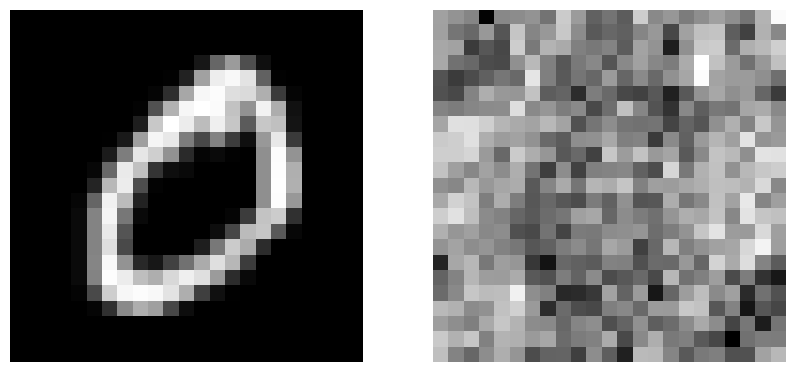

In [62]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=1
axs[0].imshow(trainset.dataset[idx]['target'].squeeze(0), cmap= 'gray')
axs[1].imshow(trainset.dataset[idx]['img'].squeeze(0), cmap= 'gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()